In [17]:
import pandas as pd
import json
import matplotlib.pyplot as plt
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

text     0
label    0
dtype: int64


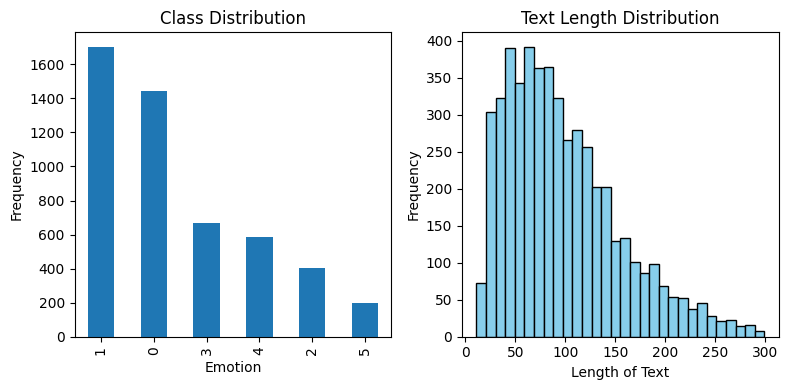

In [18]:
data = []
with open('dataset.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

missing_values = df.isnull().sum()

print(missing_values)


class_distribution = df['label'].value_counts()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
class_distribution.plot(kind='bar', title='Class Distribution', xlabel='Emotion', ylabel='Frequency')

df['text_length'] = df['text'].apply(len)
text_length_stats = df['text_length'].describe()

plt.subplot(1, 2, 2)
plt.hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

